In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
    .appName("Parquet EDA") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/16 16:27:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
parquet_directory = "/Users/seonminhwang/Downloads/yellow_tripdata_2024-01.parquet"

In [4]:
df = spark.read.parquet(parquet_directory)
df.head()

Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2024, 1, 1, 0, 57, 55), tpep_dropoff_datetime=datetime.datetime(2024, 1, 1, 1, 17, 43), passenger_count=1, trip_distance=1.72, RatecodeID=1, store_and_fwd_flag='N', PULocationID=186, DOLocationID=79, payment_type=2, fare_amount=17.7, extra=1.0, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=1.0, total_amount=22.7, congestion_surcharge=2.5, Airport_fee=0.0)

## Task 1. Pre-Processing

- Extraction of Time Components: extracted day, month, year, and time from the tpep_pickup_datetime column to separate columns (pickup_day, pickup_month, pickup_year).
- Labeling Holidays: used the USFederalHolidayCalendar to identify if a particular day is a holiday or not (is_holiday)
- 15-Minute, 30-Minute, and 60-Minute Indexing: calculated a 15/30/60min index for each record, representing which block of the day the pickup occurred. This was done by dividing the total minutes past midnight by 15/30/60.

In [5]:
from pyspark.sql.functions import dayofmonth, month, hour, minute, year

# Filter selected features for the task: tpep_pickup_datetime and PULocationID 
df_task1 = df["tpep_pickup_datetime","PULocationID"]

# Add pickup: day, month, time columns to df
df_task1 = df_task1.withColumn("pickup_year", year("tpep_pickup_datetime"))
df_task1 = df_task1.withColumn("pickup_day", dayofmonth("tpep_pickup_datetime"))
df_task1 = df_task1.withColumn("pickup_month", month("tpep_pickup_datetime"))
df_task1 = df_task1.withColumn("pickup_time", hour("tpep_pickup_datetime") * 60 + minute("tpep_pickup_datetime"))

# Show the modified DataFrame structure and some rows to verify
df_task1.printSchema()
df_task1.show()

root
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_time: integer (nullable = true)

+--------------------+------------+-----------+----------+------------+-----------+
|tpep_pickup_datetime|PULocationID|pickup_year|pickup_day|pickup_month|pickup_time|
+--------------------+------------+-----------+----------+------------+-----------+
| 2024-01-01 00:57:55|         186|       2024|         1|           1|         57|
| 2024-01-01 00:03:00|         140|       2024|         1|           1|          3|
| 2024-01-01 00:17:06|         236|       2024|         1|           1|         17|
| 2024-01-01 00:36:38|          79|       2024|         1|           1|         36|
| 2024-01-01 00:46:51|         211|       2024|         1|           1|         46|
| 2024-01-01 00:54:08|         148|       

In [6]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import BooleanType
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# Function to determine if a date is a holiday
def is_holiday(date):
    year, month, day = date.year, date.month, date.day
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=f'{year}-01-01', end=f'{year}-12-31').to_pydatetime()
    return pd.Timestamp(year, month, day) in holidays

# Register UDF
is_holiday_udf = udf(is_holiday, BooleanType())

# Apply UDF to create a new column 'is_holiday'
df_task1 = df_task1.withColumn("is_holiday", is_holiday_udf(col("tpep_pickup_datetime")))

# Show the modified DataFrame structure and some rows to verify
df_task1.printSchema()
df_task1.show()

root
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- is_holiday: boolean (nullable = true)



+--------------------+------------+-----------+----------+------------+-----------+----------+
|tpep_pickup_datetime|PULocationID|pickup_year|pickup_day|pickup_month|pickup_time|is_holiday|
+--------------------+------------+-----------+----------+------------+-----------+----------+
| 2024-01-01 00:57:55|         186|       2024|         1|           1|         57|      true|
| 2024-01-01 00:03:00|         140|       2024|         1|           1|          3|      true|
| 2024-01-01 00:17:06|         236|       2024|         1|           1|         17|      true|
| 2024-01-01 00:36:38|          79|       2024|         1|           1|         36|      true|
| 2024-01-01 00:46:51|         211|       2024|         1|           1|         46|      true|
| 2024-01-01 00:54:08|         148|       2024|         1|           1|         54|      true|
| 2024-01-01 00:49:44|         138|       2024|         1|           1|         49|      true|
| 2024-01-01 00:30:40|         246|       2024|   

In [10]:
from pyspark.sql.functions import col, hour, minute, floor

# Create 15 min index
df_task1 = df_task1.withColumn("15min_index", floor((hour(col("tpep_pickup_datetime")) * 60 + minute(col("tpep_pickup_datetime"))) / 15))
df_task1 = df_task1.withColumn("30min_index", floor((hour(col("tpep_pickup_datetime")) * 60 + minute(col("tpep_pickup_datetime"))) / 30))
df_task1 = df_task1.withColumn("60min_index", floor((hour(col("tpep_pickup_datetime")) * 60 + minute(col("tpep_pickup_datetime"))) / 60))

# Show the modified DataFrame structure and some rows to verify
df_task1.printSchema()
df_task1.show()

root
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- is_holiday: boolean (nullable = true)
 |-- 15min_index: long (nullable = true)
 |-- 30min_index: long (nullable = true)
 |-- 60min_index: long (nullable = true)



+--------------------+------------+-----------+----------+------------+-----------+----------+-----------+-----------+-----------+
|tpep_pickup_datetime|PULocationID|pickup_year|pickup_day|pickup_month|pickup_time|is_holiday|15min_index|30min_index|60min_index|
+--------------------+------------+-----------+----------+------------+-----------+----------+-----------+-----------+-----------+
| 2024-01-01 00:57:55|         186|       2024|         1|           1|         57|      true|          3|          1|          0|
| 2024-01-01 00:03:00|         140|       2024|         1|           1|          3|      true|          0|          0|          0|
| 2024-01-01 00:17:06|         236|       2024|         1|           1|         17|      true|          1|          0|          0|
| 2024-01-01 00:36:38|          79|       2024|         1|           1|         36|      true|          2|          1|          0|
| 2024-01-01 00:46:51|         211|       2024|         1|           1|         46|

## Visualization to confirm pre-processing data

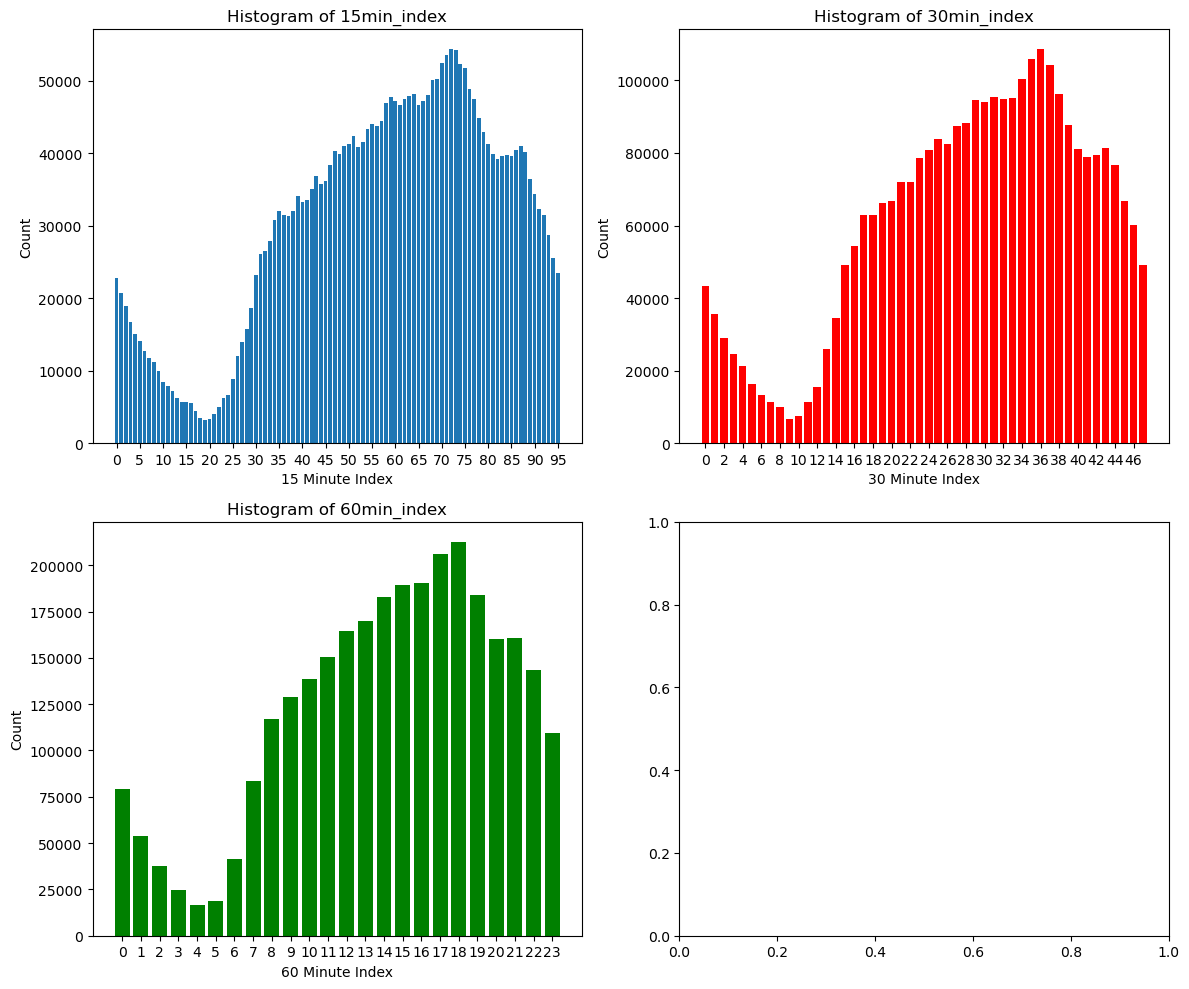

In [26]:
# Plotting
import matplotlib.pyplot as plt

# Convert to pd (For histogram Visualization)
hist_data_15min = df_task1.groupBy("15min_index").count().orderBy("15min_index")
hist_data_30min = df_task1.groupBy("30min_index").count().orderBy("30min_index")
hist_data_60min = df_task1.groupBy("60min_index").count().orderBy("60min_index")

hist_pd_15min = hist_data_15min.toPandas()
hist_pd_30min = hist_data_30min.toPandas()
hist_pd_60min = hist_data_60min.toPandas()

# Create a figure and a set of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plotting on the first axis for 15min_index
ax[0,0].bar(hist_pd_15min['15min_index'], hist_pd_15min['count'])
ax[0,0].set_xlabel('15 Minute Index')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Histogram of 15min_index')
ax[0,0].set_xticks(range(0, 96, 5))

# Plotting on the second axis for 30min_index
ax[0,1].bar(hist_pd_30min['30min_index'], hist_pd_30min['count'], color='red')
ax[0,1].set_xlabel('30 Minute Index')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title('Histogram of 30min_index')
ax[0,1].set_xticks(range(0, 48, 2))

# Plotting on the second axis for 60min_index
ax[1,0].bar(hist_pd_60min['60min_index'], hist_pd_60min['count'], color='green')
ax[1,0].set_xlabel('60 Minute Index')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title('Histogram of 60min_index')
ax[1,0].set_xticks(range(0, 24, 1))

# Display the plot
plt.tight_layout()
plt.show()